# Classify gestures by reading muscle activity

# 실험 요약

이 기말과제에서는, EMG 데이터를 활용해 손동작을 구분하는 Classification 문제를 해결하고자 하였다.

초반부에는 데이터를 탐색하고 시각화하는 과정을 통해 데이터의 특징을 이해하고자 하였다.

이후에는 Machine Learning 모델들과 Deep Learning 모델들을 적용하고 여기에 validation set을 통해 hyperparameter tuning, 구조 개선, Ensemble 기법 등을 활용하여 성능을 극대화하였다.

그 결과 test set 기준 최대 97.38%의 정확도를 달성할 수 있었다.

# 선정한 데이터 설명 및 데이터 출처

사람이 근육을 사용하여 몸을 움직일 때는 근전도(EMG)라는 것이 발생한다. 근전도는 근육에 있는 신경섬유에서 나오는 전기적 신호들이 합쳐져 발생하며, 이를 통해 근육의 상태나 행동 특징에 대해 파악할 수 있다. 최근의 연구 결과를 살펴보면, 일반적인 근육의 상태나 움직임을 파악할 수 있는 것뿐만 아니라 근육 관련 질환, 나아가 파킨슨병까지 진단할 수 있다고 한다. 최근에는 MYO라는 간편한 휴대용 근전도 기록 기기가 나와 보다 간편하게 application을 만들 수 있게 되었다. 

이번 기말과제에서 선정한 데이터는 Kaggle에 공개된 데이터셋, 'Classify gestures by reading muscle activity: a recording of human hand muscle activity producing four different hand gestures' (https://www.kaggle.com/kyr7plus/emg-4/home) 다. 데이터 자체가 흥미로울 뿐만 아니라 추후 다양한 어플리케이션, 특히 헬스케어 등 다양한 분야로 확장할 수 있다는 점이 매력적으로 느껴져 기말과제 주제로 선정하였다. 또한 공간적, 시간적으로 의미가 있는 데이터인 것 같아 기존의 머신러닝 모델뿐만 아니라 해당 특징을 가진 데이터에 효과적인 딥러닝 모델을 적용할 때 성능이 어떻게 나올지 궁금하기도 했다.

이 데이터셋은 MYO라는 **EMG** 기록 기기로 **4가지의 손동작(가위, 바위, 보, ok)**을 기록한 데이터들로 이루어져 있다. **8개의 센서**가 **8개의 연속된 시점**으로 기록되어, 하나의 instance당 **64개의 feature**를 가지고 있다. 각 class당 약 2900개 내외의 데이터를 가지고 있어 **총 11,678개의 instance**가 데이터셋으로 공개되었다. 각 데이터는 200 Hz로 기록되었는데 이는 **40ms**의 단위로 기록되었음을 의미한다.

데이터 형식은 아래와 같이 주어진다.

[8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]

그리고 gesture class는 rock - 0, scissors - 1, paper - 2, ok - 3로 주어진다.

따라서 이 기말과제의 목적은 **EMG 데이터를 활용하여 손동작 클래스를 구분하는 Classification 문제**를 푸는 것이다.

# 실험 설계 및 방법

    • 자신이 선정한 모델 및 모델 선정에 대한 이유
    • 분석에 시도한 trial 및 error 에 대한 설명(초기 모델에서 기대 이하의 성능이 나올 경우, 모델의 설정에 다양한 변화를 주고 validation 을 통해 개선되는 점을 보여줄 것)
    • Data set 을 train-set, validation-set, test-set 으로 구분하여 사용하며, 최종 모델 평가는 test-set 을 통해 평가
    • 실험 설계 및 평가 분석에 overfitting 의 관점이 사용되어야 함.

## 라이브러리 불러오기 

In [1]:
# 라이브러리에서 가끔 발생하는 warning 무시 (보고서 가독성에 안 좋아서)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 전처리, 자료형, 시각화 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 머신러닝 모델 라이브러리
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

## 데이터 불러오기 

In [5]:
# load csv files by class
data_rock = pd.read_csv('./emg-4/0.csv',header=None)
data_scissors = pd.read_csv('./emg-4/1.csv',header=None)
data_paper = pd.read_csv('./emg-4/2.csv',header=None)
data_ok = pd.read_csv('./emg-4/3.csv',header=None)

In [6]:
data = pd.concat([data_rock,data_scissors,data_paper,data_ok],axis=0,ignore_index=True) # 데이터 통합하기

## 데이터 탐색 

데이터의 특징을 간단하게 알아보고 및 preprocessing을 진행하기 위해, 데이터 탐색을 진행한다.

### data.info() 

data.info() 함수를 통해 각 column의 데이터 개수, null 여부, 자료형을 확인한다.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11678 entries, 0 to 11677
Data columns (total 65 columns):
0     11678 non-null float64
1     11678 non-null float64
2     11678 non-null float64
3     11678 non-null float64
4     11678 non-null float64
5     11678 non-null float64
6     11678 non-null float64
7     11678 non-null float64
8     11678 non-null float64
9     11678 non-null float64
10    11678 non-null float64
11    11678 non-null float64
12    11678 non-null float64
13    11678 non-null float64
14    11678 non-null float64
15    11678 non-null float64
16    11678 non-null float64
17    11678 non-null float64
18    11678 non-null float64
19    11678 non-null float64
20    11678 non-null float64
21    11678 non-null float64
22    11678 non-null float64
23    11678 non-null float64
24    11678 non-null float64
25    11678 non-null float64
26    11678 non-null float64
27    11678 non-null float64
28    11678 non-null float64
29    11678 non-null float64
30    11678 non-null 

### data.describe() 

data.describe() 함수를 통해 데이터의 평균, 표준편차, 최소/최대값, 4분위값을 알아본다.

In [9]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-0.932694,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094,1.503254
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,15.158993,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091,1.117541
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000,0.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-8.000000,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000,1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,2.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,6.000000,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000,3.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000,3.000000


### Histogram 그리기 

64개의 feature의 분포에 대해 Label별로 색깔을 정해(파랑-바위, 주황-가위, 초록-보, 빨강-ok) Histogram을 그려 시각화.

8x8 배열에서 row는 8개의 연속된 시점, column은 8개의 sensor로 생각하면 된다.

대부분 정규분포를 따르고 있는 것으로 보이며, outlier는 크게 보이지 않는다.

다만 7번째 sensor에서 바위 class의 deviation이 큰 것으로 관찰되어, 이 부분은 rule-based로 잘 구분할 수 있을 것으로 예상된다.

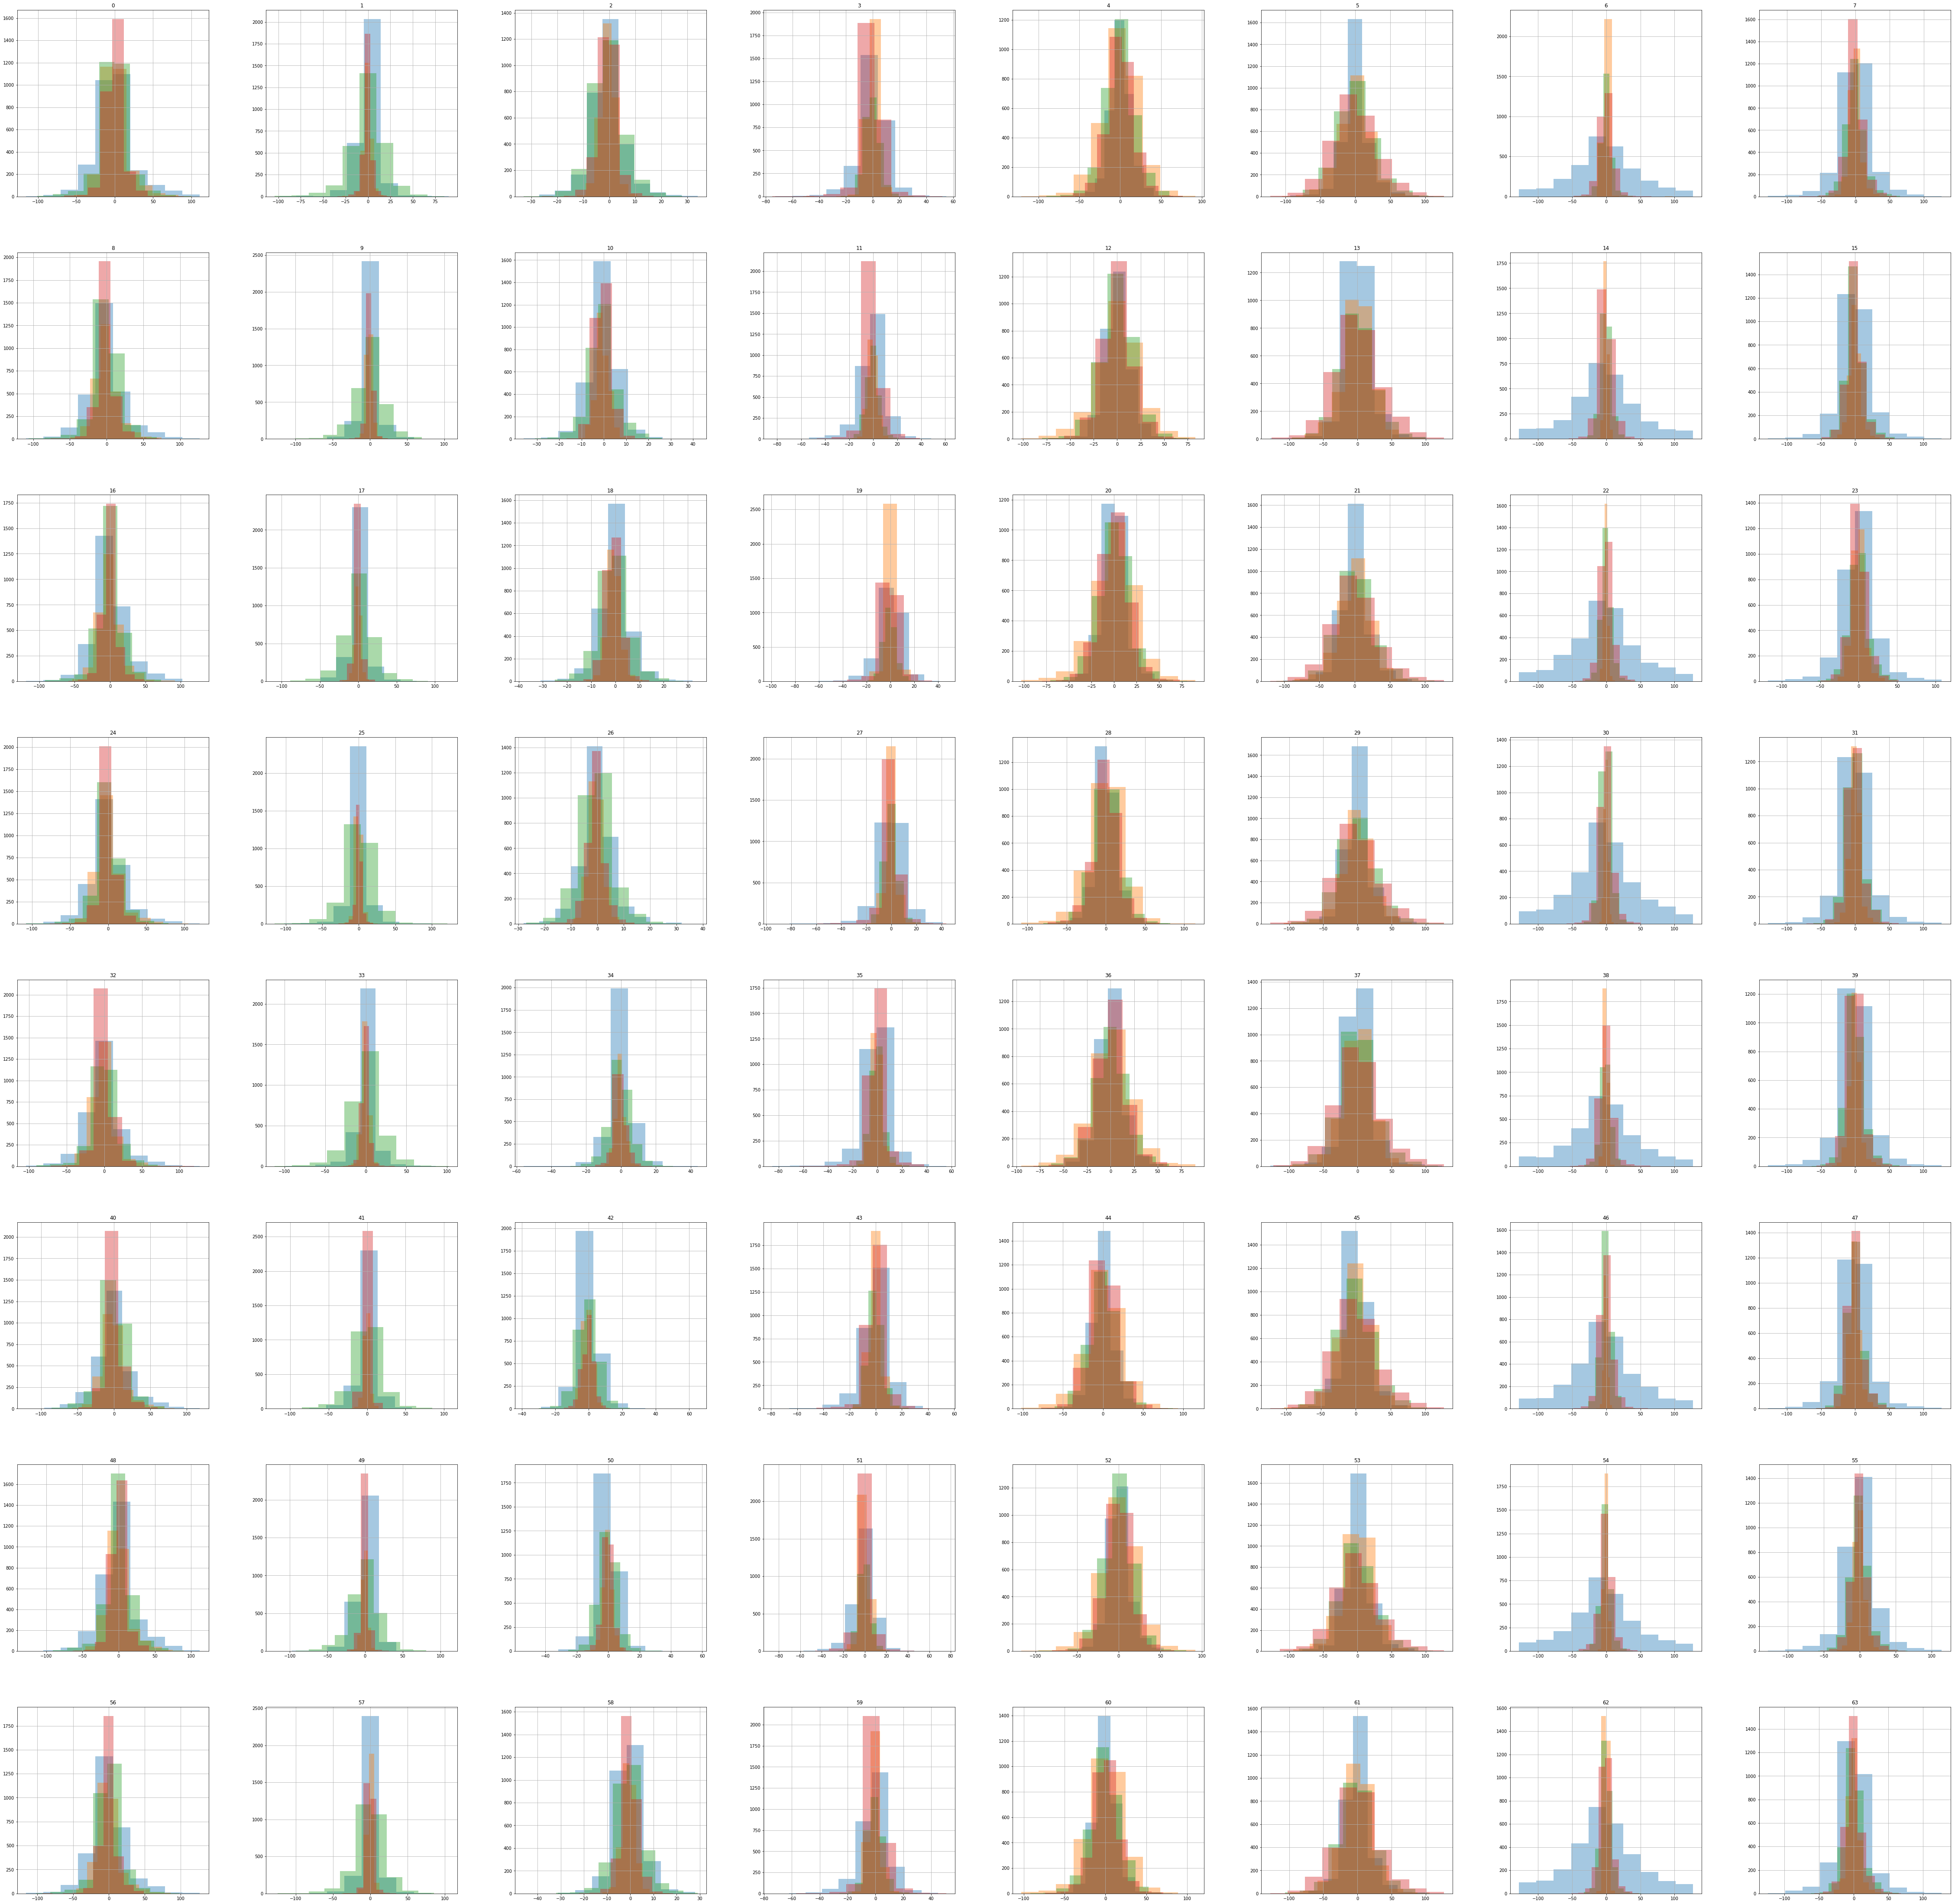

In [10]:
fig, axes = plt.subplots(8,8,figsize=(80,80))
for i in range(0,8):
    for j in range(0,8):
        data[[i*8+j,64]].groupby(64).hist(alpha=0.4,ax=axes[i][j])

plt.show()

## 데이터 train / test / validation 나누기 

60:20:20의 비율로 train / test / validation set을 나누었다.

In [7]:
X_train, X_, y_train, y_ = train_test_split(data.iloc[:,:64], data[64], test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [8]:
X_train.shape

(7006, 64)

In [9]:
X_test.shape

(2336, 64)

In [10]:
X_val.shape

(2336, 64)

In [11]:
y_train.shape

(7006,)

In [12]:
y_test.shape

(2336,)

In [13]:
y_val.shape

(2336,)

# 실험: 모델 적용 

## Baseline

다른 모델과의 비교를 위해 Baseline model을 사용하였다.

Baseline model로는 `sklearn`의 `DummyClassifier`를 활용하였다. 

현재 클래스 분포가 25:25:25:25로 균등하기 때문에 이와 비슷한 0.25 정도로 정확도가 나오고 있다.

In [225]:
baseline_stratified = DummyClassifier("stratified")
baseline_most_frequent = DummyClassifier("most_frequent")
baseline_uniform = DummyClassifier("uniform")

In [226]:
baseline_stratified.fit(X_train,y_train)
baseline_most_frequent.fit(X_train,y_train)
baseline_uniform.fit(X_train,y_train)
print("baseline - stratified acc:",baseline_stratified.score(X_val,y_val))
print("baseline - most frequent acc:",baseline_most_frequent.score(X_val,y_val))
print("baseline - uniform acc:",baseline_uniform.score(X_val,y_val))

baseline - stratified acc: 0.238013698630137
baseline - most frequent acc: 0.2512842465753425
baseline - uniform acc: 0.2422945205479452


## Logistic Regression

가장 기본적인 Classifier인 Logistic regression부터 시작해보았다. 데이터가 Linear한 특성을 보인다면 Logistic Regression 만으로도 어느 정도의 성능을 보일 것이다. 

그러나 데이터에 non-linear한 feature가 많은 것인지 hyperparameter를 tuning하지 않은 첫번째 시도에서는 34.8%로 낮은 정확도를 보였다. 

train set과 validation set의 정확도를 비교해보니, 둘 다 비슷하게 낮은 것을 관찰할 수 있었다. 성능이 낮은 이유는 overfitting 때문이라기보다는 이 데이터셋에 있어서 linear model 자체가 가지는 한계점으로 보인다. 

`sklearn` 내부 라이브러리의 Logistic Regression이 가진 hyperparameter인 `solver`와 `multi_class`로 tuning을 시도하였으나 그다지 성능 향상이 크지 않았다. 

In [20]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,y_train)
print("Logistic Regression train acc:",lr_classifier.score(X_train,y_train))
print("Logistic Regression val acc:",lr_classifier.score(X_val,y_val))

Logistic Regression train acc: 0.38067370825007135
Logistic Regression val acc: 0.3480308219178082


In [37]:
warnings.filterwarnings('ignore')
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solver in solver_list:
    lr_classifier = LogisticRegression(solver=solver)
    lr_classifier.fit(X_train,y_train)
    print("===== Solver:",solver,"=====")
    print("Logistic Regression train acc:",lr_classifier.score(X_train,y_train))
    print("Logistic Regression val acc:",lr_classifier.score(X_val,y_val))

===== Solver: newton-cg =====
Logistic Regression train acc: 0.38067370825007135
Logistic Regression val acc: 0.3480308219178082
===== Solver: lbfgs =====
Logistic Regression train acc: 0.38024550385383954
Logistic Regression val acc: 0.348458904109589
===== Solver: liblinear =====
Logistic Regression train acc: 0.38067370825007135
Logistic Regression val acc: 0.3480308219178082
===== Solver: sag =====
Logistic Regression train acc: 0.3781044818726806
Logistic Regression val acc: 0.3407534246575342
===== Solver: saga =====
Logistic Regression train acc: 0.37582072509277764
Logistic Regression val acc: 0.336472602739726


In [22]:
multiclass_list = ['ovr', 'multinomial']
for multiclass in multiclass_list:
    lr_classifier = LogisticRegression(solver='lbfgs',multi_class=multiclass)
    lr_classifier.fit(X_train,y_train)
    print("===== multi_class:",multiclass,"=====")
    print("Multiclass-",multiclass,"Logistic Regression train acc:",lr_classifier.score(X_train,y_train))
    print("Multiclass-",multiclass,"Logistic Regression val acc:",lr_classifier.score(X_val,y_val))

===== multi_class: ovr =====
Multiclass- ovr Logistic Regression train acc: 0.38024550385383954
Multiclass- ovr Logistic Regression val acc: 0.348458904109589
===== multi_class: multinomial =====
Multiclass- multinomial Logistic Regression train acc: 0.3809591778475592
Multiclass- multinomial Logistic Regression val acc: 0.3480308219178082


## K Nearest Neighbor 

다음은 non-parametric method인 k-nearest neighbors 알고리즘을 사용하였다. non paramateric이라 데이터셋의 분포에 상관 없이 robust한 결과를 기대할 수 있기에 적용해보았다.

초기 기본값 설정은 67.72로 그렇게 높지는 않지만 그래도 logistic regression에 비하면 꽤 높은 수치를 얻을 수 있었다. 

validation과 training set의 정확도 차이가 그렇게 크지 않은 것으로 보아(10%p 이내) 마찬가지로 overfitting이 크지 않다.

KNN의 hyperparameter인 `k`를 tuning 해봤을 때, 기본값인 5가 가장 좋았다. 3에서는 overfitting이 다소 크게 관찰되었다(validation-training set 정확도 차이가 10%p 이상). 그리고 알고리즘이나 tree 기반 알고리즘에서 leaf의 개수는 성능에 그다지 큰 향상을 가져오지 못했다.

In [23]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train,y_train)
print("K Nearest Neighbor train acc:",knn_classifier.score(X_train,y_train))
print("K Nearest Neighbor val acc:",knn_classifier.score(X_val,y_val))

K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602


In [24]:
k_list = [3,5,10,15,20]
for k in k_list:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train,y_train)
    print("===== k:",k,"=====")
    print("K Nearest Neighbor train acc:",knn_classifier.score(X_train,y_train))
    print("K Nearest Neighbor val acc:",knn_classifier.score(X_val,y_val))

===== k: 3 =====
K Nearest Neighbor train acc: 0.7880388238652584
K Nearest Neighbor val acc: 0.6690924657534246
===== k: 5 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== k: 10 =====
K Nearest Neighbor train acc: 0.7146731373108763
K Nearest Neighbor val acc: 0.6738013698630136
===== k: 15 =====
K Nearest Neighbor train acc: 0.6948330002854696
K Nearest Neighbor val acc: 0.6733732876712328
===== k: 20 =====
K Nearest Neighbor train acc: 0.6817013988010276
K Nearest Neighbor val acc: 0.6665239726027398


In [25]:
algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']
for alg in algorithm_list:
    knn_classifier = KNeighborsClassifier(algorithm=alg)
    knn_classifier.fit(X_train,y_train)
    print("===== algorithm:",alg,"=====")
    print("K Nearest Neighbor train acc:",knn_classifier.score(X_train,y_train))
    print("K Nearest Neighbor val acc:",knn_classifier.score(X_val,y_val))

===== algorithm: auto =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== algorithm: ball_tree =====
K Nearest Neighbor train acc: 0.7636311732800457
K Nearest Neighbor val acc: 0.6772260273972602
===== algorithm: kd_tree =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== algorithm: brute =====
K Nearest Neighbor train acc: 0.7637739080787896
K Nearest Neighbor val acc: 0.6772260273972602


In [26]:
leaf_size_list = [10,20,30,40,50]
for leaf_size in leaf_size_list:
    knn_classifier = KNeighborsClassifier(algorithm='kd_tree',leaf_size=leaf_size)
    knn_classifier.fit(X_train,y_train)
    print("===== leaf size:",leaf_size,"=====")
    print("K Nearest Neighbor train acc:",knn_classifier.score(X_train,y_train))
    print("K Nearest Neighbor val acc:",knn_classifier.score(X_val,y_val))

===== leaf size: 10 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== leaf size: 20 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== leaf size: 30 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== leaf size: 40 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== leaf size: 50 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602


## Support Vector Machine 

Support Vector Machine Classifier은 데이터의 특성이 몇 개 안 되더라도 복잡한 hyperplane을 만들 수 있다는 장점이 있어 사용하였다.

SVM의 경우 기본값으로 시도해봤을 때 training data의 정확도는 100%에 달하는 반면 validation data의 정확도는 25.12%에 불과해 상당히 큰 overfitting 양상을 보이고 있었다.

이를 해결하기 위해 다양한 `kernel`을 시도해보았는데, linear는 너무 running time이 오래 걸리기도 하고 결과도 썩 좋지 않아 제외하고 시도하였다. 그 결과 polynomial kernel이 53.63%로 가장 성능이 좋았다. polynomial kernel의 degree를 tuning해보았는데, 그 결과 degree=2에서 90.02%로 가장 높은 정확도를 보여주었다.

In [27]:
svm_classifier = SVC()
svm_classifier.fit(X_train,y_train)
print("Support Vector Machine train acc:",svm_classifier.score(X_train,y_train))
print("Support Vector Machine val acc:",svm_classifier.score(X_val,y_val))

Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.2512842465753425


In [28]:
kernel_list = ['poly', 'rbf', 'sigmoid']
for kernel in kernel_list:
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train,y_train)
    print("===== kernel type:",kernel,"=====")
    print("Support Vector Machine train acc:",svm_classifier.score(X_train,y_train))
    print("Support Vector Machine val acc:",svm_classifier.score(X_val,y_val)) 

===== kernel type: poly =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.5363869863013698
===== kernel type: rbf =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.2512842465753425
===== kernel type: sigmoid =====
Support Vector Machine train acc: 0.12603482729089352
Support Vector Machine val acc: 0.1331335616438356


In [29]:
degree_list = [2,3,4,5,6,7,8]
for degree in degree_list:
    svm_classifier = SVC(kernel='poly',degree=degree)
    svm_classifier.fit(X_train,y_train)
    print("===== polynomial degree:",degree,"=====")
    print("Support Vector Machine train acc:",svm_classifier.score(X_train,y_train))
    print("Support Vector Machine val acc:",svm_classifier.score(X_val,y_val)) 

===== polynomial degree: 2 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.9002568493150684
===== polynomial degree: 3 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.5363869863013698
===== polynomial degree: 4 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.7868150684931506
===== polynomial degree: 5 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.4785958904109589
===== polynomial degree: 6 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.6399828767123288
===== polynomial degree: 7 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.4285102739726027
===== polynomial degree: 8 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.5419520547945206


## Decision Tree 

다음은 Rule-based 결정 모델인 Decision Tree를 적용해보았다. 결과를 해석하고 이해하기 쉽기 때문에 사후 분석에도 도움이 될 것이다.

Decision Tree의 특성상 training data의 정확도는 굉장히 높다. 반면 validation data에서는 76.54%로 비교적 낮은 정확도를 보이고 있다. 이 때 발생하는 overfitting을 방지하기 위해 hyperparameter를 tuning해야 한다.

`max_depth`와 `max_features` 두 hyperparameter를 tuning해 보았는데, `max_depth`는 20일 때, `max_features`는 30일 때 78.76%로 가장 높은 성능을 보여주었다.

사후 `feature_importance_` 분석을 통해 중요한 feature를 살펴보았는데, 후반 시점, Sensor 7과 Sensor 2가 Classification에 중요한 요소로 나타났다.

In [14]:
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train,y_train)
print("Decition Tree train acc:",DT_classifier.score(X_train,y_train))
print("Decition Tree val acc:",DT_classifier.score(X_val,y_val))

Decition Tree train acc: 1.0
Decition Tree val acc: 0.759845890410959


In [20]:
max_depth_list = [10,20,25,30,40,50,70,100]
for depth in max_depth_list:
    DT_classifier = DecisionTreeClassifier(max_depth=depth)
    DT_classifier.fit(X_train,y_train)
    print("===== Max depth:",depth,"=====")
    print("Decition Tree train acc:",DT_classifier.score(X_train,y_train))
    print("Decition Tree val acc:",DT_classifier.score(X_val,y_val))

===== Max depth: 10 =====
Decition Tree train acc: 0.8362831858407079
Decition Tree val acc: 0.7512842465753424
===== Max depth: 20 =====
Decition Tree train acc: 0.9734513274336283
Decition Tree val acc: 0.7761130136986302
===== Max depth: 25 =====
Decition Tree train acc: 0.9884384813017414
Decition Tree val acc: 0.7675513698630136
===== Max depth: 30 =====
Decition Tree train acc: 0.9927205252640594
Decition Tree val acc: 0.7675513698630136
===== Max depth: 40 =====
Decition Tree train acc: 0.995717956037682
Decition Tree val acc: 0.7658390410958904
===== Max depth: 50 =====
Decition Tree train acc: 0.9982871824150727
Decition Tree val acc: 0.7615582191780822
===== Max depth: 70 =====
Decition Tree train acc: 1.0
Decition Tree val acc: 0.7654109589041096
===== Max depth: 100 =====
Decition Tree train acc: 1.0
Decition Tree val acc: 0.7568493150684932


In [26]:
max_features_list = ['sqrt','log2',10,20,30,40,50]
for max_features in max_features_list:
    DT_classifier = DecisionTreeClassifier(max_features=max_features,max_depth=20)
    DT_classifier.fit(X_train,y_train)
    print("===== Max features:",max_features,"=====")
    print("Decition Tree train acc:",DT_classifier.score(X_train,y_train))
    print("Decition Tree val acc:",DT_classifier.score(X_val,y_val))

===== Max features: sqrt =====
Decition Tree train acc: 0.9470453896660006
Decition Tree val acc: 0.7521404109589042
===== Max features: log2 =====
Decition Tree train acc: 0.9394804453325721
Decition Tree val acc: 0.7491438356164384
===== Max features: 10 =====
Decition Tree train acc: 0.948044533257208
Decition Tree val acc: 0.7585616438356164
===== Max features: 20 =====
Decition Tree train acc: 0.9607479303454182
Decition Tree val acc: 0.7649828767123288
===== Max features: 30 =====
Decition Tree train acc: 0.96117613474165
Decition Tree val acc: 0.7876712328767124
===== Max features: 40 =====
Decition Tree train acc: 0.9667427918926634
Decition Tree val acc: 0.7846746575342466
===== Max features: 50 =====
Decition Tree train acc: 0.9747359406223237
Decition Tree val acc: 0.785958904109589


In [34]:
data_label_list = list()
for i in range(1,9):
    for j in range(1,9):
        if i == 1:
            num_suffix = 'st'
        elif i == 2:
            num_suffix = 'nd'
        elif i == 3:
            num_suffix = 'rd'
        else:
            num_suffix = 'th'
        data_label_list.append("Sensor_%d in %d%s time point" %(j,i,num_suffix))
        
for feature_importance,label in sorted(zip(DT_classifier.feature_importances_,data_label_list),reverse=True):
    print(label,":",feature_importance)

Sensor_7 in 8th time point : 0.19536034700913685
Sensor_2 in 8th time point : 0.1269835210241773
Sensor_7 in 6th time point : 0.1221602754234544
Sensor_7 in 1st time point : 0.05173594325101338
Sensor_7 in 2nd time point : 0.03742798110842434
Sensor_2 in 3rd time point : 0.036330778353169405
Sensor_2 in 6th time point : 0.034338391915209876
Sensor_7 in 5th time point : 0.031213111590980103
Sensor_7 in 3rd time point : 0.02517603479250004
Sensor_7 in 4th time point : 0.023163168284426165
Sensor_2 in 4th time point : 0.022376398452698818
Sensor_2 in 1st time point : 0.02071642883441708
Sensor_6 in 8th time point : 0.02045696306026249
Sensor_7 in 7th time point : 0.015005649466161924
Sensor_2 in 2nd time point : 0.01485659491183458
Sensor_6 in 6th time point : 0.012778862854205403
Sensor_2 in 7th time point : 0.012451806021576143
Sensor_2 in 5th time point : 0.01042567761092696
Sensor_6 in 2nd time point : 0.010419663469079743
Sensor_1 in 8th time point : 0.00977802497962571
Sensor_6 in 7

## Random Forest

Decision Tree에 이어서 Decision Tree의 Ensemble 모델인 Random Forest를 적용해보았다. Ensemble model이기 때문에 단일 Decision Tree보다 성능이 좋고 outlier나 overfitting에서도 비교적 robust한 모습을 보일 것이라 예상한다.

실제로 기본 설정으로만 보았을 때, Ensemble 모델인 만큼 Decision Tree의 성능보다 10% 이상 높은 87.5%의 정확도를 보인다. training set이 validation set보다 다소 높아(약 12%p) overfitting으로 의심될 여지도 있지만, Rule-based 모델이라는 점을 감안하면 그렇게 심각한 overfitting으로 보이지는 않는다. 

Hyperparameter tuning을 위해 `n_estimators`(Forest 내 Tree의 개수)와 `max_depth`, `max_features`를 조정해보았다. 그 결과 `n_estimator`가 500일 때, `max_depth`가 50일 때, `max_features`가 log2(n_features)일 때 91.3%로 가장 좋은 성능을 보여주었다.

Decision Tree와 비슷하게, 사후 `feature_importance_` 분석을 통해 중요한 feature를 살펴보았는데, 마찬가지로 Sensor 7과 Sensor 2가 Classification에 중요한 요소로 나타났다.

In [35]:
RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train,y_train)
print("Random Forest train acc:",RF_classifier.score(X_train,y_train))
print("Random Forest val acc:",RF_classifier.score(X_val,y_val))

Random Forest train acc: 0.9964316300314017
Random Forest val acc: 0.8732876712328768


In [36]:
n_estimator_list = [3,5,8,9,10,20,30,50,100,200,300,400,500,600]
for n_estimator in n_estimator_list:
    RF_classifier = RandomForestClassifier()
    RF_classifier.fit(X_train,y_train)
    print("===== Number of trees in the forest:",n_estimator,"=====")
    print("Random Forest train acc:",RF_classifier.score(X_train,y_train))
    print("Random Forest val acc:",RF_classifier.score(X_val,y_val))

===== Number of trees in the forest: 3 =====
Random Forest train acc: 0.9967170996288895
Random Forest val acc: 0.8788527397260274
===== Number of trees in the forest: 5 =====
Random Forest train acc: 0.9965743648301456
Random Forest val acc: 0.872431506849315
===== Number of trees in the forest: 8 =====
Random Forest train acc: 0.9971453040251214
Random Forest val acc: 0.872431506849315
===== Number of trees in the forest: 9 =====
Random Forest train acc: 0.9964316300314017
Random Forest val acc: 0.8745719178082192
===== Number of trees in the forest: 10 =====
Random Forest train acc: 0.9977162432200971
Random Forest val acc: 0.8720034246575342
===== Number of trees in the forest: 20 =====
Random Forest train acc: 0.9971453040251214
Random Forest val acc: 0.8711472602739726
===== Number of trees in the forest: 30 =====
Random Forest train acc: 0.9977162432200971
Random Forest val acc: 0.8792808219178082
===== Number of trees in the forest: 50 =====
Random Forest train acc: 0.996574364

In [41]:
max_depth_list = [10,20,25,30,40,50,70,100]
for depth in max_depth_list:
    RF_classifier = RandomForestClassifier(n_estimators=500,max_depth=depth)
    RF_classifier.fit(X_train,y_train)
    print("===== Max depth:",depth,"=====")
    print("Random Forest train acc:",RF_classifier.score(X_train,y_train))
    print("Random Forest val acc:",RF_classifier.score(X_val,y_val))

===== Max depth: 10 =====
Random Forest train acc: 0.9349129317727662
Random Forest val acc: 0.8839897260273972
===== Max depth: 20 =====
Random Forest train acc: 0.9875820725092778
Random Forest val acc: 0.9096746575342466
===== Max depth: 25 =====
Random Forest train acc: 0.9932914644590352
Random Forest val acc: 0.9083904109589042
===== Max depth: 30 =====
Random Forest train acc: 0.9961461604339138
Random Forest val acc: 0.9092465753424658
===== Max depth: 40 =====
Random Forest train acc: 0.9992863260062803
Random Forest val acc: 0.9092465753424658
===== Max depth: 50 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9126712328767124
===== Max depth: 70 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9105308219178082
===== Max depth: 100 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9096746575342466


In [42]:
max_features_list = ['sqrt','log2',10,20,30,40,50]
for max_features in max_features_list:
    RF_classifier = RandomForestClassifier(max_features=max_features,n_estimators=500,max_depth=50)
    RF_classifier.fit(X_train,y_train)
    print("===== Max features:",max_features,"=====")
    print("Random Forest train acc:",RF_classifier.score(X_train,y_train))
    print("Random Forest val acc:",RF_classifier.score(X_val,y_val))

===== Max features: sqrt =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9083904109589042
===== Max features: log2 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9126712328767124
===== Max features: 10 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9071061643835616
===== Max features: 20 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9075342465753424
===== Max features: 30 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9053938356164384
===== Max features: 40 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9092465753424658
===== Max features: 50 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9083904109589042


In [39]:
data_label_list = list()
for i in range(1,9):
    for j in range(1,9):
        if i == 1:
            num_suffix = 'st'
        elif i == 2:
            num_suffix = 'nd'
        elif i == 3:
            num_suffix = 'rd'
        else:
            num_suffix = 'th'
        data_label_list.append("Sensor_%d in %d%s time point" %(j,i,num_suffix))
        
for feature_importance,label in sorted(zip(RF_classifier.feature_importances_,data_label_list),reverse=True):
    print(label,":",feature_importance)

Sensor_7 in 8th time point : 0.09056300205264592
Sensor_7 in 6th time point : 0.08972268298935049
Sensor_7 in 4th time point : 0.08740877037451528
Sensor_7 in 1st time point : 0.05614369173633858
Sensor_2 in 8th time point : 0.054815720307927154
Sensor_7 in 2nd time point : 0.048253853815974426
Sensor_7 in 5th time point : 0.047621910497069826
Sensor_2 in 2nd time point : 0.04383668440089346
Sensor_7 in 7th time point : 0.04194818131169801
Sensor_2 in 5th time point : 0.04121406452817646
Sensor_2 in 3rd time point : 0.029499500224367543
Sensor_7 in 3rd time point : 0.028523071442676518
Sensor_2 in 6th time point : 0.028327169789273438
Sensor_2 in 7th time point : 0.02829923170732733
Sensor_2 in 4th time point : 0.020543686022205816
Sensor_2 in 1st time point : 0.020170193681643304
Sensor_6 in 4th time point : 0.00993787720867477
Sensor_6 in 6th time point : 0.009452251538500829
Sensor_6 in 8th time point : 0.009447182865768563
Sensor_6 in 7th time point : 0.008528899910145727
Sensor_6 

## Deep Neural Network 

`Tensorflow` backend의 `keras` 프레임워크를 활용해서 Deep Neural Network 모델을 적용해보았다.

8개의 센서와 8개의 연속된 시점이라는 특징을 고려해보았을 때, 8개의 센서는 공간적 특징을 가지고 있으니 CNN을, 8개의 연속된 시점은 시계열이라는 특징을 가지고 있으니 RNN, LSTM을 사용해보았다. 이후 이 두 개의 특징을 모두 결합한 CNN-LSTM과 같은 하이브리드 모델도 시도해보았다.

## CNN 

In [174]:
import keras.backend as K
from keras import models, layers, optimizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [93]:
def alexnet_variation(input_shape, n_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32,(3,3),activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(256,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(512,(3,3),activation='relu',padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [94]:
cnn = alexnet_variation(input_shape=(8,8,1),n_classes=4)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 512)         1180160   
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               4194432   
__________

In [54]:
y_train_DL = to_categorical(y_train)
y_val_DL = to_categorical(y_val)
y_test_DL = to_categorical(y_test)
X_train_CNN = np.array(X_train).reshape(X_train.shape[0],8,8,1)
X_val_CNN = np.array(X_val).reshape(X_val.shape[0],8,8,1)
X_test_CNN = np.array(X_test).reshape(X_test.shape[0],8,8,1)

In [55]:
hist = cnn.fit(X_train_CNN,y_train_DL,epochs=100,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)

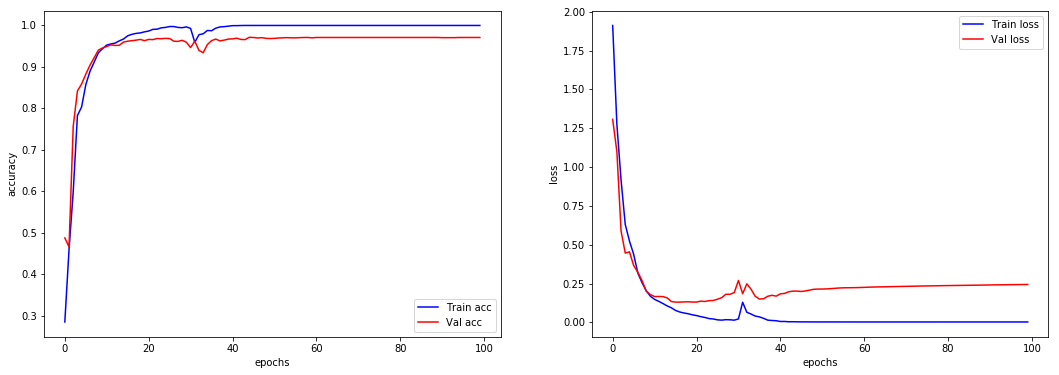

In [56]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

epoch 20을 시점으로 validation loss가 상승하기 때문에, 이 기점을 기준으로 training을 중단하면 overfitting을 막을 수 있다.

In [109]:
cnn = alexnet_variation(input_shape=(8,8,1),n_classes=4)
hist = cnn.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
print("CNN accuracy:",accuracy_score(y_val,np.argmax(cnn.predict(X_val_CNN),axis=1)))

CNN accuracy: 0.9657534246575342


## RNN 

In [137]:
def simple_rnn(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.SimpleRNN(32, input_shape=input_shape))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [138]:
X_train_RNN = np.array(X_train).reshape(X_train.shape[0],8,8)
X_val_RNN = np.array(X_val).reshape(X_val.shape[0],8,8)
X_test_RNN = np.array(X_test).reshape(X_test.shape[0],8,8)

In [139]:
rnn = simple_rnn(input_shape=(8,8),n_classes=4)
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 32)                1312      
_________________________________________________________________
dense_85 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_86 (Dense)             (None, 4)                 260       
Total params: 3,684
Trainable params: 3,684
Non-trainable params: 0
_________________________________________________________________


In [140]:
hist = rnn.fit(X_train_RNN, y_train_DL, epochs=1000,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)

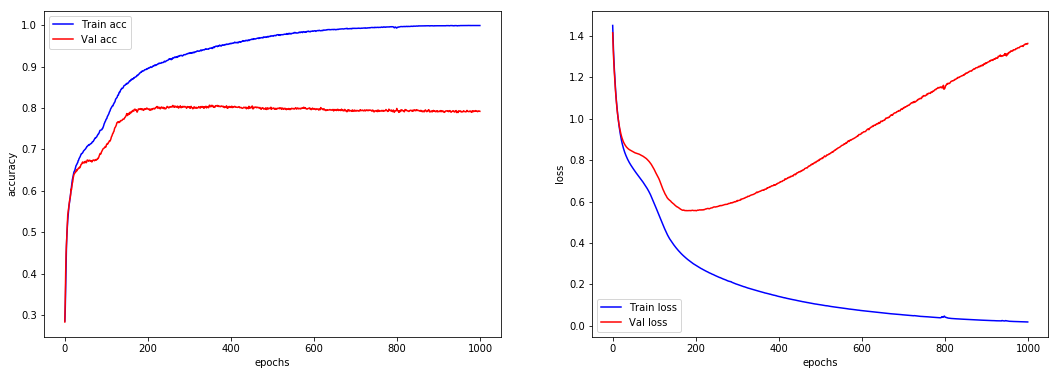

In [141]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

epoch 200을 시점으로 validation loss가 상승하기 때문에, 이 기점을 기준으로 training을 중단하면 overfitting을 막을 수 있다.

In [142]:
rnn = simple_rnn(input_shape=(8,8),n_classes=4)
hist = rnn.fit(X_train_RNN, y_train_DL, epochs=200,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)
print("RNN accuracy:",accuracy_score(y_val,np.argmax(rnn.predict(X_val_RNN),axis=1)))

RNN accuracy: 0.752568493150685


## LSTM 

In [136]:
def LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.LSTM(32, input_shape=input_shape,return_sequences=True))
    model.add(layers.LSTM(64,return_sequences=True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [132]:
lstm = LSTM(input_shape=(8,8),n_classes=4)
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 8, 32)             5248      
_________________________________________________________________
lstm_38 (LSTM)               (None, 8, 64)             24832     
_________________________________________________________________
lstm_39 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_81 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 516       
Total params: 145,924
Trainable params: 145,924
Non-trainable params: 0
_________________________________________________________________


In [133]:
hist = lstm.fit(X_train_RNN, y_train_DL, epochs=100,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)

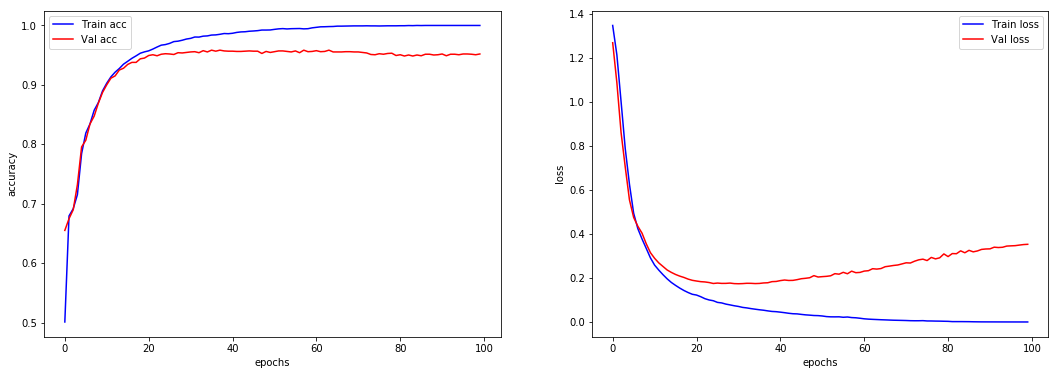

In [134]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

epoch 25을 시점으로 validation loss가 상승하기 때문에, 이 기점을 기준으로 training을 중단하면 overfitting을 막을 수 있다.

In [135]:
lstm = LSTM(input_shape=(8,8),n_classes=4)
hist = lstm.fit(X_train_RNN, y_train_DL, epochs=25,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)
print("LSTM accuracy:",accuracy_score(y_val,np.argmax(lstm.predict(X_val_RNN),axis=1)))

LSTM accuracy: 0.9434931506849316


## CNN-LSTM 

In [101]:
def CNN_LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(32,3,activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.Conv1D(64,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(128,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(256,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(256,3,activation='relu',padding='same'))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [67]:
cnn_lstm = CNN_LSTM(input_shape=(8,8),n_classes=4)
cnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 32)             800       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 64)             6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 128)            24704     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 8, 256)            98560     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 256)            196864    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8, 128)            197120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 128)            131584    
__________

In [68]:
hist = cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=100,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)

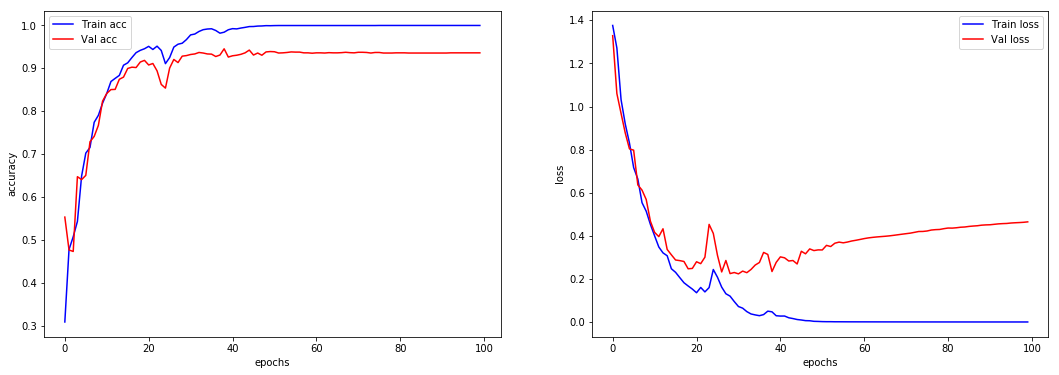

In [69]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

epoch 30을 시점으로 validation loss가 상승하기 때문에, 이 기점을 기준으로 training을 중단하면 overfitting을 막을 수 있다.

In [112]:
cnn_lstm = CNN_LSTM(input_shape=(8,8),n_classes=4)
hist = cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=30,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)
print("CNN-LSTM accuracy:",accuracy_score(y_val,np.argmax(cnn_lstm.predict(X_val_RNN),axis=1)))

CNN-LSTM accuracy: 0.930222602739726


## Shallow CNN-LSTM 

In [104]:
def shallow_CNN_LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(32,3,activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [71]:
shallow_cnn_lstm = shallow_CNN_LSTM(input_shape=(8,8),n_classes=4)
shallow_cnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 8, 32)             800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 516       
Total params: 34,468
Trainable params: 34,468
Non-trainable params: 0
_________________________________________________________________


In [72]:
hist = shallow_cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=300,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)

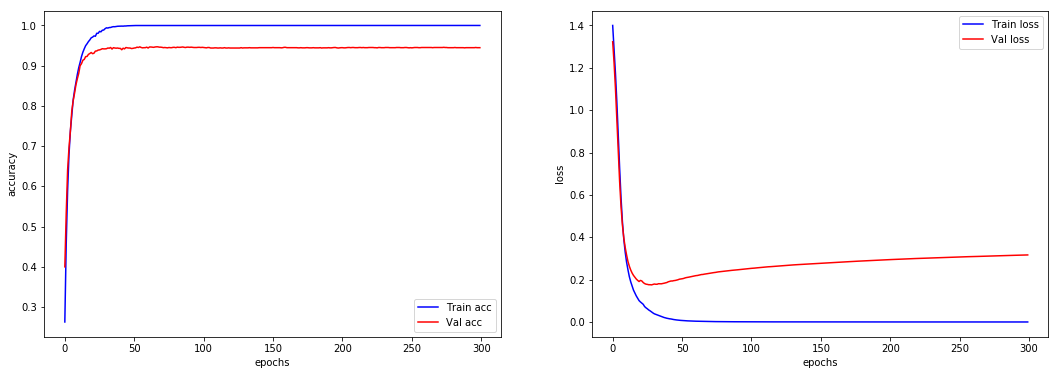

In [73]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

epoch 25를 시점으로 validation loss가 상승하기 때문에, 이 기점을 기준으로 training을 중단하면 overfitting을 막을 수 있다.

In [113]:
shllow_cnn_lstm = shallow_CNN_LSTM(input_shape=(8,8),n_classes=4)
hist = shallow_cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=25,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)
print("Shallow CNN-LSTM accuracy:",accuracy_score(y_val,np.argmax(shallow_cnn_lstm.predict(X_val_RNN),axis=1)))

Shallow CNN-LSTM accuracy: 0.946917808219178


## CNN tuning 

Deep Learning 모델 중에서 가장 좋은 성능을 보인 것은 CNN이었다. 

사실 EMG의 특성상 sensor의 공간적 위치에 따른 spatial feature가 중요한 feature가 될 것 같은데, 이러한 공간적 feature를 가장 잘 활용할 수 있는 CNN이 가장 좋은 성능이 나온 것 같다.

CNN-LSTM의 성능이 다소 낮게 나온 것은 아쉽지만, 8개의 time point 정도는 단순히 CNN 정도로 연관성을 해석해도 별 무리가 없는 정도이기 때문에 CNN이 더 효과가 좋았던 것 같다.

더불어 이 데이터의 feature 개수가 8개의 sensor에서 나온 8개의 time point라서, 만약에 time point 기준으로 하면 feature가 8개씩밖에 없는 것이라 이용할 수 있는 feature의 개수도 너무 적은 편이긴 하다. 그래서 8x8=64개를 공간/시간적으로 모두 연관성을 활용할 수 있는 CNN이 가장 좋은 것 같다.

위에서 활용한 CNN은 AlexNet 구조의 변형으로, overfitting을 막기 위해 training/validation loss를 기준으로 epoch만을 정했을 뿐, 그 외의 구조나 hyperparameter tuning은 하지 않았다. 그럼에도 96.75%라는 높은 성능을 보여주기는 하지만, 여기에서 여러 가지 방법을 더 활용해 성능을 극대화해보자.

### Batch normalization

Batch normalization을 사용해보았더니 96.57% -> 97.08%로 약간의 성능 향상이 있었다. Learning curve를 보면 학습도 좀 더 빠르고 안정적으로 수렴되는 모습을 보이며, Loss도 (비록 큰 차이는 아니지만) 쓰지 않았을 때보다 낮은 모습을 보이고 있다.

In [144]:
def alexnet_variation_tuning(input_shape, n_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32,(3,3),padding='same',input_shape=input_shape))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [145]:
cnn_tuning = alexnet_variation_tuning(input_shape=(8,8,1),n_classes=4)

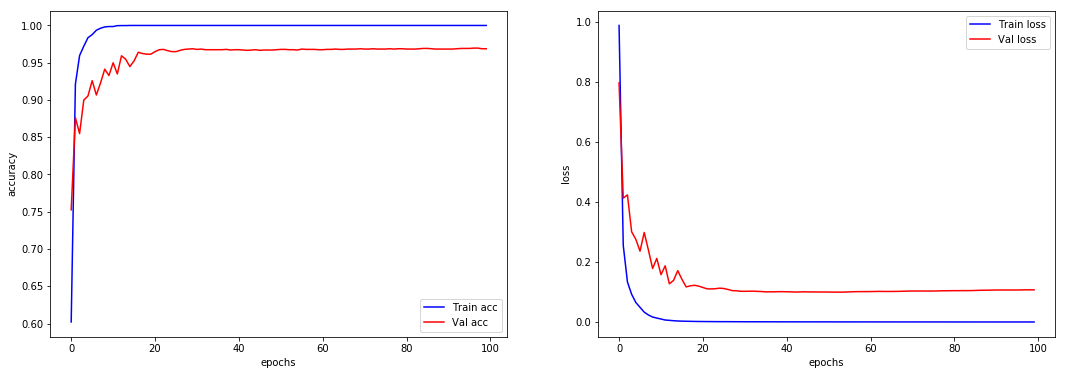

In [146]:
hist = cnn_tuning.fit(X_train_CNN,y_train_DL,epochs=100,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [147]:
cnn_tuning = alexnet_variation_tuning(input_shape=(8,8,1),n_classes=4)
hist = cnn_tuning.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
print("CNN accuracy:",accuracy_score(y_val,np.argmax(cnn_tuning.predict(X_val_CNN),axis=1)))

CNN accuracy: 0.9708904109589042


### Optimizer

현재는 Optimizer로 Adam을 쓰고 있지만, 다른 Optimizer를 써보면 어떨까 싶어 시도해보았다. Nesterov Adam, Adamax optimizer, Adadelta, SGD를 써보았다. 그러나 Adam에 비해 그렇게 크게 성능이 좋아보이지는 않아 그냥 Adam을 사용하기로 한다.

In [153]:
def alexnet_variation_tuning_optimizer(input_shape, n_classes, optimizer):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32,(3,3),padding='same',input_shape=input_shape))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

===== Optimizer: adam =====


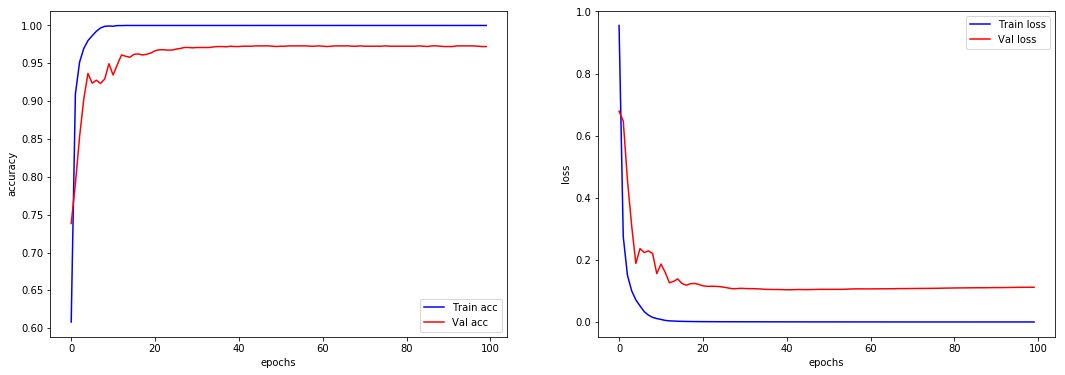

===== Optimizer: nadam =====


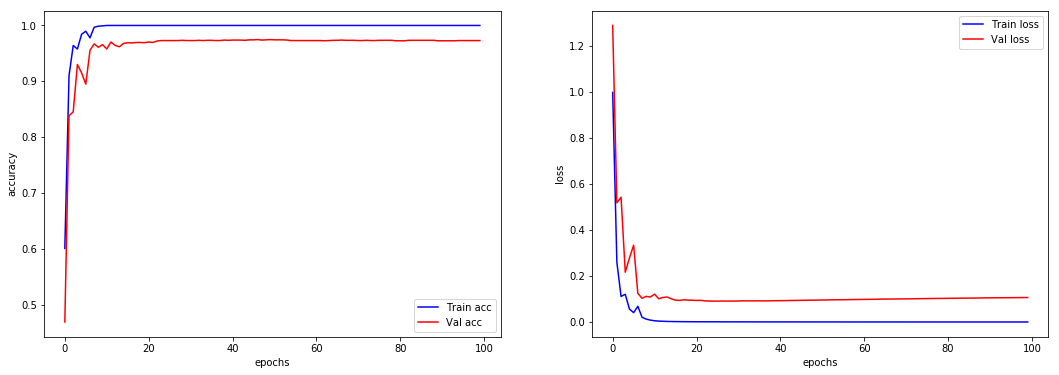

===== Optimizer: adamax =====


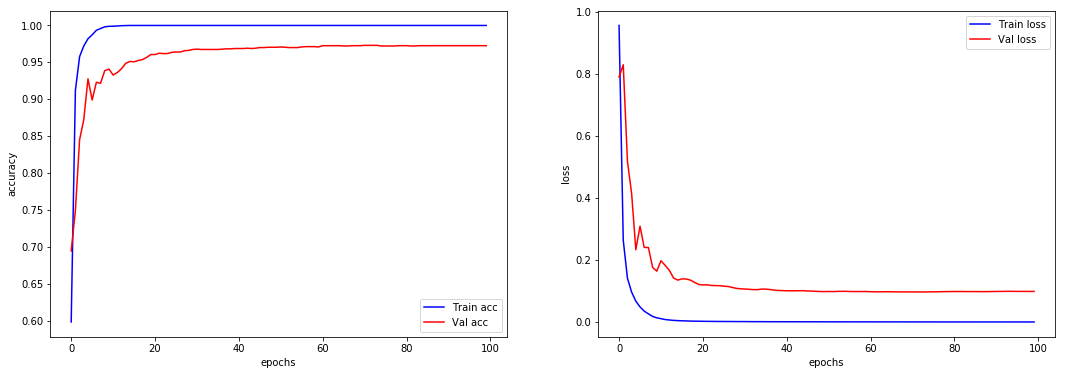

===== Optimizer: adadelta =====


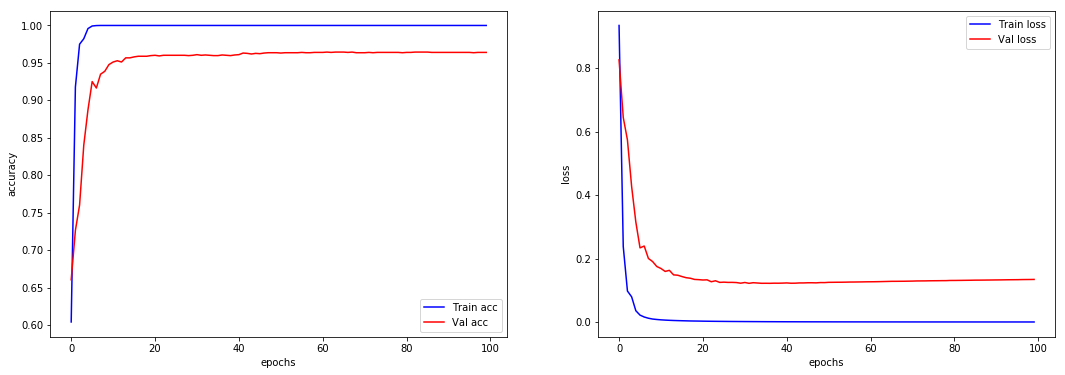

===== Optimizer: sgd =====


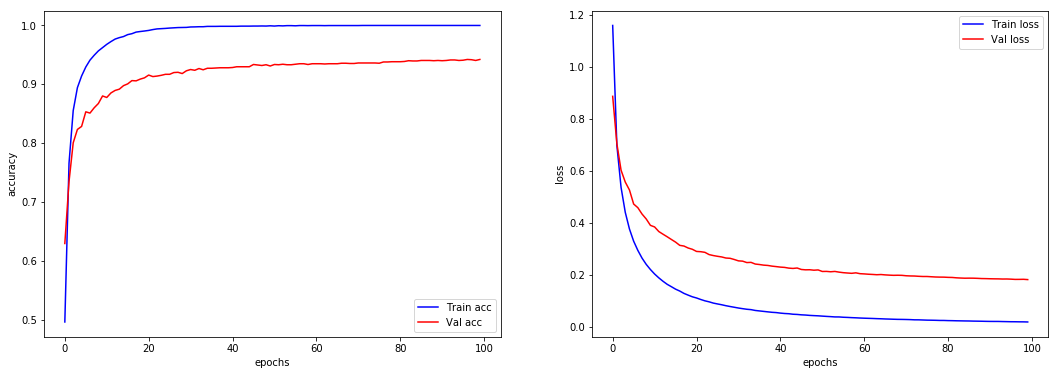

In [155]:
optimizer_list = ['adam','nadam','adamax','adadelta','sgd']
for optimizer in optimizer_list:
    cnn_tuning = alexnet_variation_tuning_optimizer(input_shape=(8,8,1),n_classes=4,optimizer=optimizer)
    print("===== Optimizer:",optimizer,"=====")
    hist = cnn_tuning.fit(X_train_CNN,y_train_DL,epochs=100,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
    line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.subplot(122)
    line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
    line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.show()

### Learning rate 

다음은 Learning rate를 조절해보았다. 현재는 기본 설정값인 0.001이며, 그 외에도 0.005,0.01,0.05,0.0001,0.0005 등 다양한 수치를 시도해보았다. 

그러나 대부분의 learning rate가 0.001 기본값보다 좋지 않았으며, 그나마 0.01이 좀 더 낫지 않을까 싶었는데 96.91% 정도로 약간 모자라는 결과를 보였다. 그래서 그냥 기본값 0.001을 쓰기로 한다.

In [159]:
def alexnet_variation_tuning_lr(input_shape, n_classes, lr):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32,(3,3),padding='same',input_shape=input_shape))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512,(3,3),padding='same'))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=lr),metrics=['acc'])
    return model

===== Learning Rate: 0.001 =====


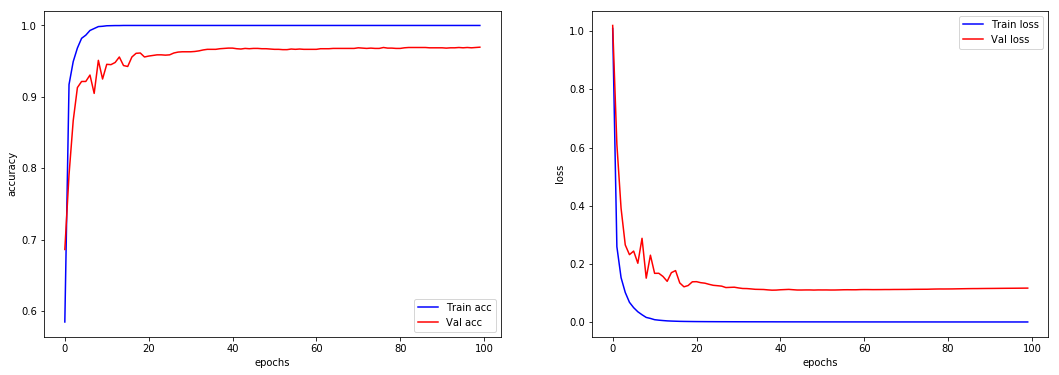

===== Learning Rate: 0.005 =====


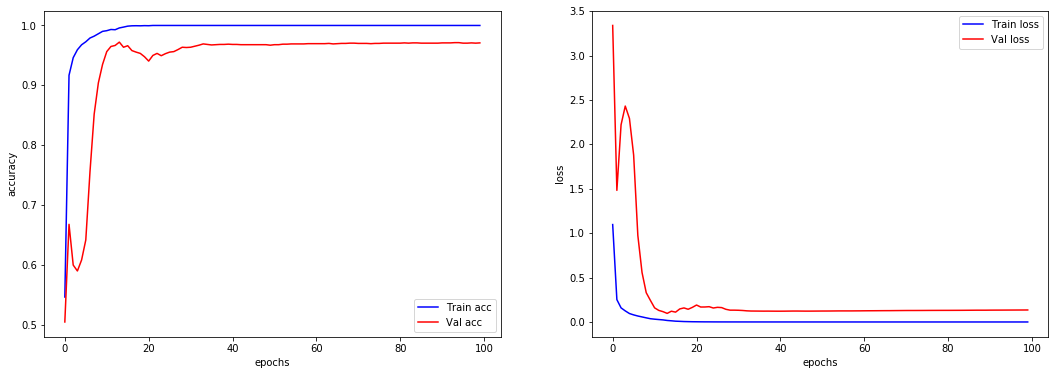

===== Learning Rate: 0.01 =====


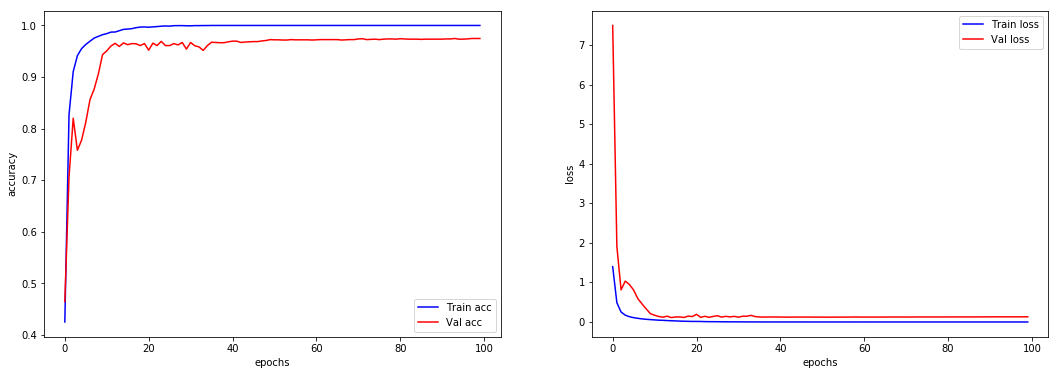

===== Learning Rate: 0.05 =====


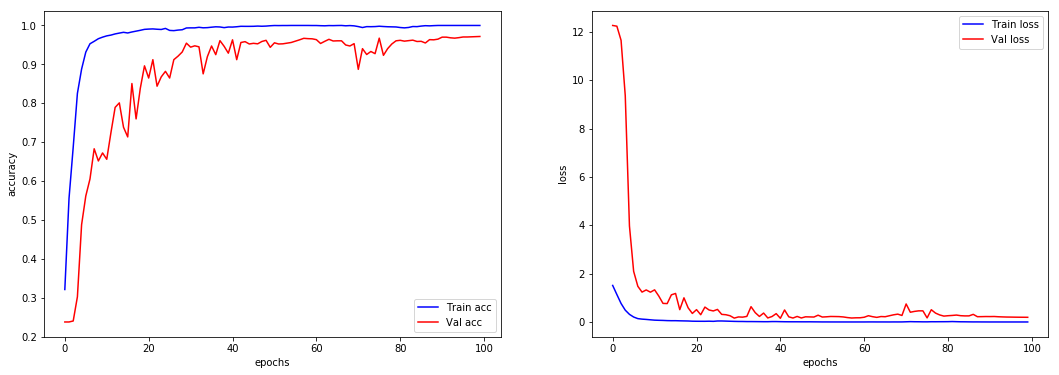

===== Learning Rate: 0.0001 =====


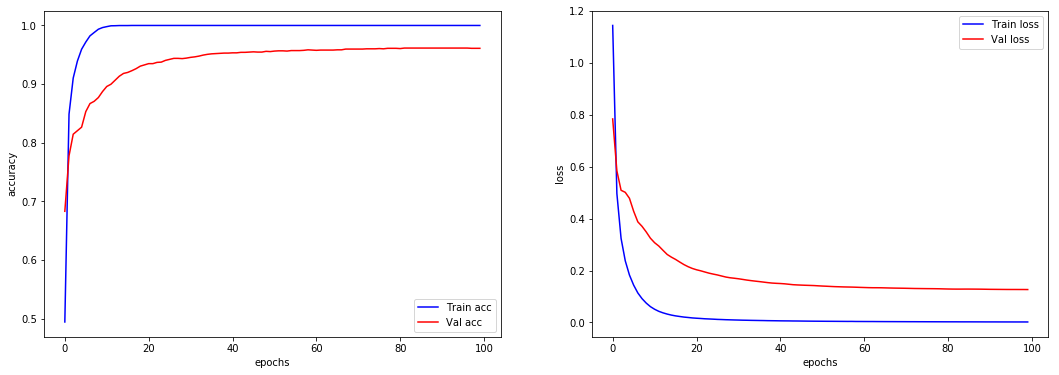

===== Learning Rate: 0.0005 =====


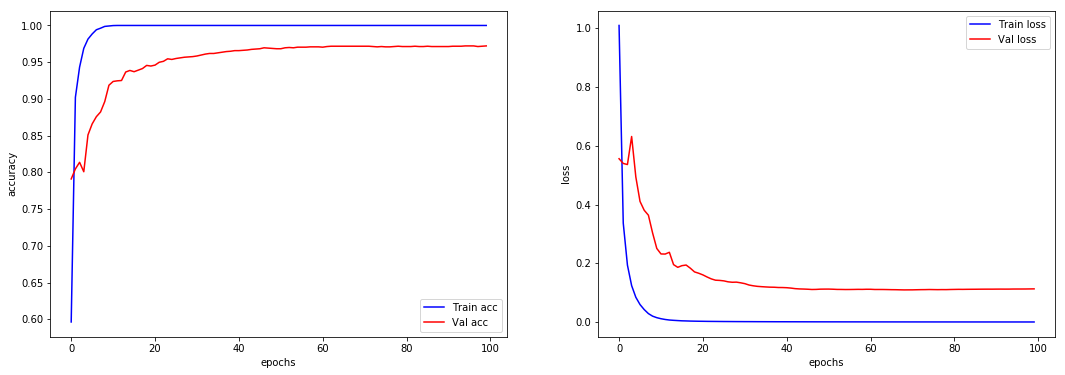

In [161]:
lr_list = [0.001,0.005,0.01,0.05,0.0001,0.0005]
for lr in lr_list:
    cnn_tuning = alexnet_variation_tuning_lr(input_shape=(8,8,1),n_classes=4,lr=lr)
    print("===== Learning Rate:",lr,"=====")
    hist = cnn_tuning.fit(X_train_CNN,y_train_DL,epochs=100,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
    line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.subplot(122)
    line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
    line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.show()

In [164]:
cnn_tuning = alexnet_variation_tuning_lr(input_shape=(8,8,1),n_classes=4,lr=0.001)
hist = cnn_tuning.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
print("CNN accuracy:",accuracy_score(y_val,np.argmax(cnn_tuning.predict(X_val_CNN),axis=1)))

CNN accuracy: 0.971318493150685


In [163]:
cnn_tuning = alexnet_variation_tuning_lr(input_shape=(8,8,1),n_classes=4,lr=0.01)
hist = cnn_tuning.fit(X_train_CNN,y_train_DL,epochs=40,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
print("CNN accuracy:",accuracy_score(y_val,np.argmax(cnn_tuning.predict(X_val_CNN),axis=1)))

CNN accuracy: 0.9691780821917808


### Ensemble 

마지막으로 여러 가지 모델을 병합하여 성능을 극대화시키는 Ensemble 기법을 사용하였다. 

여러 개의 CNN 모델을 만들고 이것의 평균으로 결과를 예측하는 Ensemble 모델을 만들었다.

Ensemble 모델을 위해서는 Keras의 Sequential 방식이 아닌 Functional 방식을 사용해야 하기 때문에 이를 활용한 새로운 함수를 만든다.

그 결과 3개의 모델을 사용하면 97.08% -> 97.26%, 5개의 모델을 사용하면 97.08% -> 97.30%로 크지는 않지만 약간의 성능 향상을 만들 수 있었다.

In [202]:
def alexnet_variation_tuning_func(model_input, n_classes):
    
    x = layers.Conv2D(32,(3,3),padding='same')(model_input)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64,(3,3),padding='same')(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128,(3,3),padding='same')(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256,(3,3),padding='same')(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512,(3,3),padding='same')(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(128)(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(n_classes,activation='softmax')(x)
    
    model = models.Model(model_input, x, name='cnn')
    
    return model

In [212]:
def ensemble(model_list, model_input):
    
    outputs = [model.outputs[0] for model in model_list]
    y = layers.Average()(outputs)
    
    model = models.Model(model_input, y, name='ensemble')
    
    return model

In [204]:
model_input = models.Input(shape=(8,8,1))

In [218]:
cnn_tuning_1 = alexnet_variation_tuning_func(model_input,n_classes=4)
cnn_tuning_1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
cnn_tuning_1.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
cnn_tuning_2 = alexnet_variation_tuning_func(model_input,n_classes=4)
cnn_tuning_2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
cnn_tuning_2.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
cnn_tuning_3 = alexnet_variation_tuning_func(model_input,n_classes=4)
cnn_tuning_3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
cnn_tuning_3.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
cnn_tuning_4 = alexnet_variation_tuning_func(model_input,n_classes=4)
cnn_tuning_4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
cnn_tuning_4.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
cnn_tuning_5 = alexnet_variation_tuning_func(model_input,n_classes=4)
cnn_tuning_5.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
cnn_tuning_5.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)

In [216]:
model_list = [cnn_tuning_1, cnn_tuning_2, cnn_tuning_3]
ensemble_model = ensemble(model_list, model_input)

In [217]:
print("Ensemble CNN accuracy:",accuracy_score(y_val,np.argmax(ensemble_model.predict(X_val_CNN),axis=1)))

Ensemble CNN accuracy: 0.9726027397260274


In [219]:
model_list = [cnn_tuning_1, cnn_tuning_2, cnn_tuning_3, cnn_tuning_4, cnn_tuning_5]
ensemble_model = ensemble(model_list, model_input)

In [220]:
print("Ensemble CNN accuracy:",accuracy_score(y_val,np.argmax(ensemble_model.predict(X_val_CNN),axis=1)))

Ensemble CNN accuracy: 0.9730308219178082


## test set을 활용한 최종 결과 evaluation 

지금까지 사용한 모든 model을 validation set 기준 가장 좋은 성능을 내는 hyperparameter setting으로 훈련한 뒤, test set을 활용해 최종 결과를 확인해보겠다.

각 모델과 hyperparameter setting은 다음과 같다.

- **Logistic Regression**: `solver`='lbfgs', `multi_class`='multinomial'
- **K Nearest Neighbos**: `n_neighbors`=5, `algorithm`='kd_tree', leaf_size=30
- **Support Vector Machine**: `kernel`='poly', `degree`=2
- **Decision Tree**: `max_features`=30, `max_depth`=20
- **Random Forest**: `max_features`='log2', `n_estimators`=500, `max_depth`=50
- **Deep Neural Network models**
    - **CNN**: `epochs`=30, `Optimizer`='Adam', `Learning rate`=0.001
    - **RNN**: `epochs`=200, `Optimizer`='Adam', `Learning rate`=0.001
    - **LSTM**: `epochs`=25, `Optimizer`='Adam', `Learning rate`=0.001
    - **CNN-LSTM**: `epochs`=30, `Optimizer`='Adam', `Learning rate`=0.001
    - **Shallow CNN-LSTM**: `epochs`=25, `Optimizer`='Adam', `Learning rate`=0.001
    - **CNN tuned**: `epochs`=30, `Batch normalization`=True, `Optimizer`='Adam', `Learning rate`=0.001, `Ensemble`: 5 models

In [223]:
acc_score = dict()

In [227]:
acc_score['baseline'] = baseline_stratified.score(X_test,y_test)

In [117]:


lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr_classifier.fit(X_train,y_train)
acc_score['Logistic Regression'] = lr_classifier.score(X_test,y_test)

knn_classifier = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree',leaf_size=30)
knn_classifier.fit(X_train,y_train)
acc_score['K Nearest Neighbors'] = knn_classifier.score(X_test,y_test)

svm_classifier = SVC(kernel='poly',degree=2)
svm_classifier.fit(X_train,y_train)
acc_score['Support Vector Machine'] = svm_classifier.score(X_test,y_test)

DT_classifier = DecisionTreeClassifier(max_features=30,max_depth=20)
DT_classifier.fit(X_train,y_train)
acc_score['Decision Tree'] = DT_classifier.score(X_test,y_test)

RF_classifier = RandomForestClassifier(max_features='log2',n_estimators=500,max_depth=50)
RF_classifier.fit(X_train,y_train)
acc_score['Random Forest'] = RF_classifier.score(X_test,y_test)

cnn = alexnet_variation(input_shape=(8,8,1),n_classes=4)
hist = cnn.fit(X_train_CNN,y_train_DL,epochs=30,batch_size=2048,validation_data=(X_val_CNN,y_val_DL),verbose=0)
acc_score['CNN'] = accuracy_score(y_test,np.argmax(cnn.predict(X_test_CNN),axis=1))

rnn = simple_rnn(input_shape=(8,8),n_classes=4)
hist = rnn.fit(X_train_RNN, y_train_DL, epochs=200,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)
acc_score['RNN'] = accuracy_score(y_test,np.argmax(rnn.predict(X_test_RNN),axis=1))

lstm = LSTM(input_shape=(8,8),n_classes=4)
hist = lstm.fit(X_train_RNN, y_train_DL, epochs=25,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)
acc_score['LSTM'] = accuracy_score(y_test,np.argmax(lstm.predict(X_test_RNN),axis=1))

cnn_lstm = CNN_LSTM(input_shape=(8,8),n_classes=4)
hist = cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=30,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)
acc_score['CNN-LSTM'] = accuracy_score(y_test,np.argmax(cnn_lstm.predict(X_test_RNN),axis=1))

shllow_cnn_lstm = shallow_CNN_LSTM(input_shape=(8,8),n_classes=4)
hist = shallow_cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=25,batch_size=2048,validation_data=(X_val_RNN,y_val_DL),verbose=0)
acc_score['Shallow CNN-LSTM'] = accuracy_score(y_test,np.argmax(shallow_cnn_lstm.predict(X_test_RNN),axis=1))

In [221]:
acc_score['CNN tuned'] = accuracy_score(y_test,np.argmax(ensemble_model.predict(X_test_CNN),axis=1))

In [228]:
sorted(acc_score.items(),key=lambda t : t[1])

[('baseline', 0.2534246575342466),
 ('Logistic Regression', 0.3467465753424658),
 ('K Nearest Neighbors', 0.6772260273972602),
 ('Decision Tree', 0.8090753424657534),
 ('RNN', 0.8090753424657534),
 ('Support Vector Machine', 0.9019691780821918),
 ('Random Forest', 0.9246575342465754),
 ('CNN-LSTM', 0.9413527397260274),
 ('LSTM', 0.9477739726027398),
 ('Shallow CNN-LSTM', 0.9580479452054794),
 ('CNN', 0.9704623287671232),
 ('CNN tuned', 0.9738869863013698)]

## 최종 결과 evaluation 해석 & 결론

test set을 활용한 최종 모델 평가 결과, validation set으로 확인한 결과와 크게 차이가 나지 않는 선에서 대부분의 모델의 결과가 나왔다.

이 중 성능이 좋았던 모델들은 SVM, Random Forest, 그리고 Deep Learning 모델들이었다.

SVM과 Random Forest는 기존 머신러닝 모델 중에서도 대부분의 데이터에 robust하게 잘 성능이 나오는 모델들이기 때문에 이 데이터셋에서도 무난하게 좋은 성능을 보여준 것 같다.

Deep learning 모델들의 경우 CNN과 LSTM 등이 애초에 이 데이터의 공간적/시계열 특성을 잘 잡아주기 때문에 이런 좋은 결과가 나온 것 같다.

중간에 feature selection을 할까 말까 고민했었는데, 64개 feature가 그렇게 엄청나게 많은 것도 아니고, 추후 Deep learning 모델에 넣기 위해서는 해당 데이터들이 가진 공간적/시계열 특징을 최대한 보존하는 것이 좋다고 생각했기 때문에 그 부분은 넘어갔다.

특이했던 점은 CNN-LSTM 결합 모델의 경우 구조가 너무 deep한 모델보다는 좀 shallow한 모델의 성능이 더 좋았는데, 아무래도 이 데이터의 feature가 instance당 64개, 그리고 이 모델에 들어갈 때는 특히 8개로 줄어들기 때문에 deep CNN-LSTM의 경우 feature space에 비해 모델이 너무 complex하지 않았나 생각한다. 실제로 learning curve를 보면 다른 모델에 비해 converge하는 속도도 느리다.

또 재밌었던 점은 단순한 CNN이 LSTM보다 3%p나 유의미하게 성능이 좋았던 점인데, 시계열이 엄청 긴 것이 아니면 CNN으로도 어느 정도 그 시계열 특성을 잡아낼 수 있다고 예전에 다른 NLP 논문을 보다가 확인했는데, 이를 실제로 확인할 수 있어 재밌었다.

그리고 추가적으로 여러 방법을 통해 CNN의 성능을 극대화시키고자 한 것도 많은 것을 배울 수 있는 경험이었다.

이번 과제는 Machine Learning 모델을 활용한 Data science 분석 파이프라인을 잘 경험해볼 수 있었다. 데이터의 특성에 대해 깊이 고민하고, 다양한 모델을 시도하고 그 모델에 hyperparmeter tuning을 해보고, 그 결과를 해석해보면서 각 모델이 가진 특징과 EMG data가 가진 domain-specific한 특징에 대해 보다 깊게 이해할 수 있는 기회였다.